In [3]:
import requests
import os
import sys
import pandas as pd
import numpy as np


from typing import Optional
import glob
from scipy import stats
# Add the parent directory of this notebook to sys.path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

from project_tools import project_utils, project_class

import datetime
import json
from tqdm.notebook import tqdm
import gc
# import ds_utils
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score
from scipy.stats import kendalltau, spearmanr
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss, accuracy_score
from scipy import stats
%matplotlib inline

from importlib import reload
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Or for more precise control
pd.set_option('display.float_format', '{:.5f}'.format)

# evaluation functions

In [4]:
def evaluate_horse_race_positions(y_true, y_pred_proba, dnf_value=99):
    """
    Evaluate predictions for a single race's finishing positions.
    
    Args:
        y_true: 1D array of true finishing positions
        y_pred_proba: 1D array of predicted probabilities
        dnf_value: Value used to indicate Did Not Finish
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Handle NaN and DNF values in ground truth
    y_true_processed = y_true.copy()
    invalid_mask = np.logical_or(
        np.isnan(y_true),
        y_true == dnf_value
    )
    
    # Get max valid rank (excluding DNF values)
    valid_ranks = y_true[~invalid_mask]
    if len(valid_ranks) > 0:
        max_rank = np.max(valid_ranks)
        # Replace invalid values with max_rank + 1
        y_true_processed[invalid_mask] = max_rank + 1
        
    # Winner match
    y_true_ranksort = np.argsort(y_true_processed)
    y_pred_ranksort = np.argsort(y_pred_proba, axis=0)[::-1]
    
    winner_match = y_true_ranksort[0] == y_pred_ranksort[0]
    
    # Top 3 Set Match - considers [1,3,2] and [2,3,1] as matching
    top3_set_match = set(y_true_ranksort[:3]) == set(y_pred_ranksort[:3])
    
    # Top 3 Exact Match - only considers exact matches like [1,3,2] and [1,3,2]
    top3_exact_match = np.array_equal(y_true_ranksort[:3], y_pred_ranksort[:3])
    
    return {
        'Winner Match': float(winner_match),
        'Top 3 Set Match': float(top3_set_match), 
        'Top 3 Exact Match': float(top3_exact_match)
    }


In [5]:
def evaluate_prediction_sets(eval_dict):
    """
    Evaluate different prediction sets against ground truth for each race and calculate mean metrics
    
    Args:
        eval_dict: Dictionary containing race data with ground truth and different prediction sets
        
    Returns:
        tuple: (eval_result, mean_results_df)
            - eval_result: Dictionary with detailed evaluation metrics for each race
            - mean_results_df: DataFrame comparing mean metrics across prediction types
    """
    # Initialize results dictionary with race_ids as first level keys
    eval_result = {race_id: {} for race_id in eval_dict}

    # Get prediction types from first race data
    first_race_id = next(iter(eval_dict))
    pred_types = [key for key in eval_dict[first_race_id].keys() if key != 'ground_truth']

    # Initialize dictionaries to store mean results
    mean_results = {pred_type: {} for pred_type in pred_types}

    # Loop through each race
    for race_id in eval_dict:
        race_data = eval_dict[race_id]
        ground_truth = race_data['ground_truth']
        
        # Evaluate each prediction type
        for pred_type in pred_types:
            pred_probs = race_data[pred_type]
            
            # Evaluate predictions for this race
            race_eval = evaluate_horse_race_positions(
                ground_truth,
                pred_probs
            )
            
            # Store results for this race under race_id first, then pred_type
            eval_result[race_id][pred_type] = race_eval

    # Calculate mean results for each prediction type
    for pred_type in pred_types:
        # Initialize dict to store means for each metric
        metric_means = {}
        
        # Get metrics from first race to know what metrics exist
        first_race = next(iter(eval_result.values()))
        metrics = first_race[pred_type].keys()
        
        # For each metric, calculate mean across all races
        for metric in metrics:
            total = 0
            num_races = 0
            for race_id in eval_result:
                total += eval_result[race_id][pred_type][metric]
                num_races += 1
            metric_means[metric] = total / num_races
            
        mean_results[pred_type] = metric_means
    
    # Convert mean results to DataFrame for easy comparison
    mean_results_df = pd.DataFrame(mean_results)
    
    return eval_result, mean_results_df

# # Run evaluation
# eval_result, mean_results_df = evaluate_prediction_sets(eval_dict)

# # Display mean results comparison
# print("\nMean Evaluation Metrics Comparison:")
# print(mean_results_df)


# pairwise ranking functions

In [7]:
def prepare_pairwise_ranking_data(df, race_id_col='race_id', label_col='clean_position',
                                  keep_race_id_col=False):
    """
    Prepare data for pairwise ranking by generating pairs of samples within each race.
    For each race, creates pairs of horses where one finished ahead of the other.
    
    Args:
        df: DataFrame containing race data
        race_id_col: Column name for race identifier
        label_col: Column name containing finishing position
        
    Returns:
        DataFrame with pairwise samples, containing features for both horses and binary label
        indicating if first horse finished ahead of second horse
    """
    feature_cols = [c for c in df.columns if c not in [race_id_col, label_col]]
    pairs_data = []
    
    # Process each race
    for race_id in df[race_id_col].unique():
        race_df = df[df[race_id_col] == race_id].copy()
        
        # Generate all pairs of horses in this race
        for i in range(len(race_df)):
            for j in range(i+1, len(race_df)):
                horse1 = race_df.iloc[i]
                horse2 = race_df.iloc[j]
                
                # Create feature vectors for both horses
                features1 = horse1[feature_cols].values
                features2 = horse2[feature_cols].values
                
                # Label is 1 if horse1 finished ahead of horse2
                label = 1 if horse1[label_col] < horse2[label_col] else 0
                if not keep_race_id_col:                
                    pairs_data.append(np.concatenate([
                        features1,features2,[label]
                    ]))                    
                    # Add reverse pair with opposite label
                    pairs_data.append(np.concatenate([
                        features2, features1,[1-label]
                    ]))
                else:
                    pairs_data.append(np.concatenate([
                        features1,features2,[label, race_id]
                    ]))                    
                    # Add reverse pair with opposite label
                    pairs_data.append(np.concatenate([
                        features2, features1,[1-label, race_id], 
                    ]))
    
    # Create column names for paired data
    pair_cols = []
    pair_cols1 = [f'{col}_1' for col in feature_cols]
    pair_cols2 = [f'{col}_2' for col in feature_cols]
    pair_cols = pair_cols1 + pair_cols2
    pair_cols.append('label')
    if keep_race_id_col:
        pair_cols.append('race_id')    
    
    return pd.DataFrame(pairs_data, columns=pair_cols)

In [8]:
def train_pairwise_ranker_ridge(train_df, val_df=None, race_id_col='race_id', label_col='clean_position',
                               alpha=1.0):
    """
    Train a Ridge Classifier model for pairwise ranking of horses.
    Converts the ranking problem into binary classification of horse pairs.
    
    Args:
        train_df: Training DataFrame with features and labels
        val_df: Optional validation DataFrame
        race_id_col: Column name for race identifier 
        label_col: Column name containing position/rank labels
        alpha: Regularization strength parameter for Ridge Classifier
        
    Returns:
        Trained model and validation predictions (if val_df provided)
    """
    from sklearn.linear_model import RidgeClassifier
    
    # Prepare pairwise training data
    print("Preparing pairwise training data...")
    train_pairs = prepare_pairwise_ranking_data(
        train_df,
        race_id_col=race_id_col,
        label_col=label_col
    )
    
    # Split features and labels
    X_train = train_pairs.drop(['label'], axis=1)
    y_train = train_pairs['label']

    print('training model')
    # Initialize and train model
    model = RidgeClassifier(alpha=alpha)
    model.fit(X_train, y_train)
    
    val_preds = None
    if val_df is not None:
        print("Preparing validation data...")
        val_pairs = prepare_pairwise_ranking_data(
            val_df,
            race_id_col=race_id_col, 
            label_col=label_col
        )
        X_val = val_pairs.drop(['label'], axis=1)
        val_preds = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_val)
        return model, val_preds
    else:
        return model

# load data

In [9]:
horse_race_df = pd.read_parquet('../feature_data/horse_race_df.parquet')
horse_race_df = horse_race_df.sort_values(by=['clean_race_date','race_id'], ascending=True).reset_index(drop=True)
basic_cat_ordinal_df = pd.read_parquet('../feature_data/basic_cat_ordinal_features.parquet')

In [11]:
target1 = 'clean_position'
df_rank = pd.read_parquet('../feature_data/baseline_features/lgbm_rank_baseline_dataset.parquet')
# df_rank[target1] = horse_race_df[target1]

In [85]:
baseline_mean_results = pd.read_parquet('../evaluation_results/valdf_random_winodd_baseline_mean_results.parquet')

In [15]:
df_rank.columns

Index(['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight',
       'clean_win_odds', 'race_distance', 'race_id', 'jockey', 'trainer',
       'race_course', 'race_course_track', 'race_class', 'track_condition',
       'jockey_bin_0', 'jockey_bin_1', 'jockey_bin_2', 'jockey_bin_3',
       'jockey_bin_4', 'jockey_bin_5', 'jockey_bin_6', 'trainer_bin_0',
       'trainer_bin_1', 'trainer_bin_2', 'trainer_bin_3', 'trainer_bin_4',
       'trainer_bin_5', 'trainer_bin_6', 'race_course_bin_0',
       'race_course_track_bin_0', 'race_course_track_bin_1',
       'race_course_track_bin_2', 'race_course_track_bin_3',
       'race_class_bin_0', 'race_class_bin_1', 'race_class_bin_2',
       'race_class_bin_3', 'track_condition_bin_0', 'track_condition_bin_1',
       'track_condition_bin_2', 'track_condition_bin_3', 'jockey_freq',
       'trainer_freq', 'race_course_freq', 'race_course_track_freq',
       'race_class_freq', 'track_condition_freq', 'awght_dwght_ratio',
       'awght_d

# feature transformation for linear model

In [17]:
imptrans = project_class.DataFrameImputationTransformer(strategy='median')
df_linear = imptrans.fit_transform(df_rank)

non_scale_cols = ['horse_number'] + [col for col in df_linear.columns if 'bin' in col]
df_linear = project_utils.minmax_scale_features(df_linear, exclude_cols=non_scale_cols)


# run model

In [18]:
basic_num_features = ['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight',
                  'clean_win_odds', 'race_distance']
basic_cat_features = basic_cat_ordinal_df.columns.tolist()

train_years = ['2014','2015','2016']
val_years = ['2017']
train_idx = horse_race_df[horse_race_df['year'].isin(train_years)].index
val_idx = horse_race_df[horse_race_df['year'].isin(val_years)].index
print(len(train_idx), len(val_idx))

23232 6288


In [23]:
# df_rank[target1] = horse_race_df[target1]
target1 = 'clean_position'
df_linear[target1] = horse_race_df[target1]
train_df = df_linear.loc[train_idx]
# train_df = train_df[train_df['clean_position']!=99].reset_index(drop=True)
val_df = df_linear.loc[val_idx]

ridge_model = train_pairwise_ranker_ridge(train_df, val_df=None)

Preparing pairwise training data...


In [25]:
pairwise_val = prepare_pairwise_ranking_data(val_df, keep_race_id_col=True)
X_val = pairwise_val.drop(['label', 'race_id'], axis=1)
y_val = pairwise_val['label']
val_preds = ridge_model.predict_proba(X_val)[:,1]
pairwise_val['prediction'] = val_preds

AttributeError: 'RidgeClassifier' object has no attribute 'predict_proba'

In [73]:
def ridge_to_proba(model, X):
    """
    Convert RidgeClassifier decision function outputs to probability estimates using softmax.
    
    Args:
        model: Trained RidgeClassifier model
        X: Input features to get predictions for
        
    Returns:
        numpy array of probability estimates
    """
    # Get decision function scores
    scores = model.decision_function(X)
    
    # Handle binary classification case
    if len(model.classes_) == 2:
        # Convert to 2D array with negative class scores
        scores = np.c_[-scores, scores]
    
    # Apply softmax to convert scores to probabilities
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    proba = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return proba

# val_preds = ridge_model.predict(X_val)
val_preds = ridge_to_proba(ridge_model, X_val)[:,1]
pairwise_val['prediction'] = val_preds

In [74]:
val_logloss = log_loss(y_val, val_preds)
val_acc = accuracy_score(y_val, val_preds > 0.5)
print(f'Validation LogLoss: {val_logloss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

Validation LogLoss: 0.5993
Validation Accuracy: 0.6825


In [75]:
groupby_feats1 = ['race_id', 'horse_number_1']
numfeats = ['prediction']
stat = ['sum']

agg_recipies = [
    [groupby_feats1, numfeats, stat],
]

res_dfs = project_utils.groupby_agg_execution(agg_recipies, pairwise_val, verbose=False)
val_race_preds = res_dfs['race_id_horse_number_1']
val_race_preds.columns = ['race_id', 'horse_number', 'prediction']

val_df1 = val_df.copy()
on_cols = ['race_id', 'horse_number']
val_df1 = val_df.merge(right=val_race_preds, on = on_cols, how='left')

In [80]:
use_race_id = val_df1['race_id'].sample(1).values[0]
use_cols = ['race_id', 'horse_number', 'clean_position','prediction']
race_df = val_df1[val_df1['race_id'] == use_race_id][use_cols].sort_values(by='prediction', ascending=False)
y_true = race_df['clean_position'].values
y_pred = race_df['prediction'].values
print(evaluate_horse_race_positions(y_true, y_pred))
race_df

{'Winner Match': 1.0, 'Top 3 Set Match': 0.0, 'Top 3 Exact Match': 0.0}


,race_id,horse_number,clean_position,prediction
1798,0.84531,4.00000,1,6.85055
1806,0.84531,2.00000,9,6.83605
1808,0.84531,5.00000,11,6.45811
1800,0.84531,11.00000,3,6.28297
1799,0.84531,3.00000,2,6.03399
1801,0.84531,10.00000,4,5.99326
1807,0.84531,1.00000,10,5.86563
1805,0.84531,6.00000,8,5.81982
1802,0.84531,9.00000,5,5.42128
1804,0.84531,12.00000,7,5.18453


In [83]:
val_horse_race_df = horse_race_df.loc[val_idx].reset_index(drop=True)
pred_col = f'ridge_pairwise_preds'
eval_dict = {}
ground_truth = {}
val_horse_race_df[pred_col] =  val_df1['prediction']


for race in val_horse_race_df['race_id'].unique():
    race_df = val_horse_race_df[val_horse_race_df['race_id']==race]
    n_horse = race_df.shape[0]    
    eval_dict[race] = {}
    eval_dict[race]['ground_truth'] = race_df['clean_position'].values
    eval_dict[race][pred_col] = race_df[pred_col].values
    
eval_result, ridge_pairwise_results_df = evaluate_prediction_sets(eval_dict)
ridge_pairwise_results_df

,ridge_pairwise_preds
Winner Match,0.26223
Top 3 Set Match,0.05284
Top 3 Exact Match,0.00783


In [72]:
# binary version:
# ridge_pairwise_results_df

,ridge_pairwise_preds
Winner Match,0.26223
Top 3 Set Match,0.05284
Top 3 Exact Match,0.00783


In [86]:
compare_results = baseline_mean_results.copy()
# compare_results[pred_col] = lgbmv1_iswinner_results_df[pred_col]
# compare_results[pred_col2] = lgbmv1_istop3_results_df[pred_col2]
compare_results[pred_col] = ridge_pairwise_results_df
compare_results

,random_probs,winning_odd_preds,ridge_pairwise_preds
Winner Match,0.07632,0.29354,0.26223
Top 3 Set Match,0.00783,0.05871,0.05284
Top 3 Exact Match,0.00196,0.00978,0.00783


In [88]:
project_utils.pickle_data('../model/ridge_pairwise_basicfeatures_deltaweight.pkl', ridge_model)

creating file ../model/ridge_pairwise_basicfeatures_deltaweight.pkl


'../model/ridge_pairwise_basicfeatures_deltaweight.pkl'

# results analysis

In [90]:
content_list = []
for key, value in eval_result.items():
    item_dict = {}
    item_dict['race_id'] = key
    item_dict['winner_match'] = value[pred_col]['Winner Match']
    item_dict['top3set'] = value[pred_col]['Top 3 Set Match']
    item_dict['top3exact'] = value[pred_col]['Top 3 Exact Match']
    content_list.append(item_dict)

eval_df = pd.DataFrame.from_dict(content_list)
print(eval_df.shape)
merge_cols = ['race_id', 'clean_race_date']
race_date_df = horse_race_df.drop_duplicates(merge_cols, keep='first')
eval_df = eval_df.merge(right=race_date_df[merge_cols], on='race_id', how='left')
print(eval_df.shape)

groupby_feats1 = ['clean_race_date']
numfeats = ['winner_match', 'top3set', 'top3exact']
stat = ['mean']

agg_recipies = [
    [groupby_feats1, numfeats, stat],
]

res_dfs = project_utils.groupby_agg_execution(agg_recipies, eval_df, verbose=False)
daily_eval = res_dfs['clean_race_date']
daily_eval.shape

(511, 4)
(511, 5)


(56, 4)

In [91]:
def convert_race_dates_and_plot_metrics3(df, date_col='race_date'):
    """
    Convert race dates from string format (YYYYMMDD) to datetime and create time series plots
    for winner match, top3 set, and top3 exact means. Only plots dates with values.
    
    Args:
        df: DataFrame containing race data with date and metric columns
        date_col: Name of column containing date strings
    """
    # Convert dates to datetime
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], format='%Y%m%d')
    
    # Remove rows where all metric columns are null
    metrics = ['winner_match_mean', 'top3set_mean', 'top3exact_mean']
    df_clean = df.dropna(subset=metrics, how='all')
    
    # Sort by date
    df_clean = df_clean.sort_values(date_col)
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    fig.tight_layout(pad=5.0)
    
    # Plot winner match mean and rolling average
    valid_winner = df_clean.dropna(subset=['winner_match_mean'])
    ax1.plot(valid_winner[date_col], valid_winner['winner_match_mean'], 
             label='Daily Mean', color='blue')
    
    # Calculate and plot 7-day rolling average
    rolling_mean = valid_winner['winner_match_mean'].rolling(window=7, min_periods=1).mean()
    ax1.plot(valid_winner[date_col], rolling_mean, 
             label='7-day Rolling Average', color='red', linestyle='--')
    
    ax1.set_title('Winner Match Mean Over Time', pad=20)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Winner Match Mean')
    ax1.grid(True)
    ax1.legend()
    
    # Plot top3 set mean
    valid_top3set = df_clean.dropna(subset=['top3set_mean'])
    ax2.plot(valid_top3set[date_col], valid_top3set['top3set_mean'])
    ax2.set_title('Top 3 Set Mean Over Time', pad=20)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Top 3 Set Mean')
    ax2.grid(True)
    
    # Plot top3 exact mean
    valid_top3exact = df_clean.dropna(subset=['top3exact_mean'])
    ax3.plot(valid_top3exact[date_col], valid_top3exact['top3exact_mean'])
    ax3.set_title('Top 3 Exact Mean Over Time', pad=20)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Top 3 Exact Mean')
    ax3.grid(True)
    
    # Rotate x-axis labels for better readability
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='x', rotation=45)
    
    plt.show()
    
    return df_clean

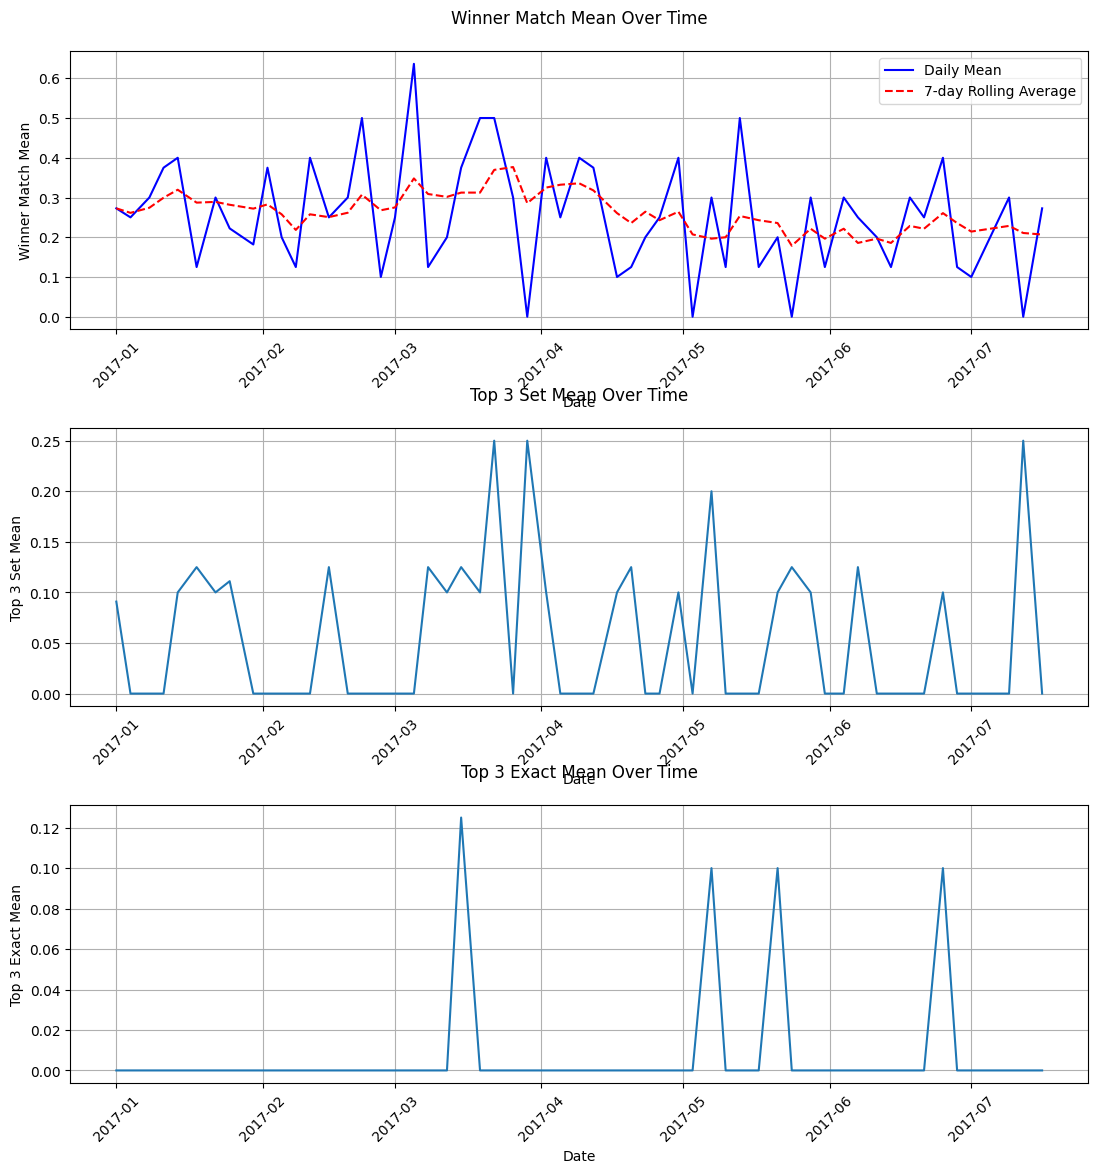

,race_date,winner_match_mean,top3set_mean,top3exact_mean
0,2017-01-01,0.27273,0.09091,0.00000
1,2017-01-04,0.25000,0.00000,0.00000
2,2017-01-08,0.30000,0.00000,0.00000
3,2017-01-11,0.37500,0.00000,0.00000
4,2017-01-14,0.40000,0.10000,0.00000
5,2017-01-18,0.12500,0.12500,0.00000
6,2017-01-22,0.30000,0.10000,0.00000
7,2017-01-25,0.22222,0.11111,0.00000
8,2017-01-30,0.18182,0.00000,0.00000
9,2017-02-02,0.37500,0.00000,0.00000


In [92]:
cols = ['race_date', 'winner_match_mean', 'top3set_mean', 'top3exact_mean']
daily_eval.columns = cols
convert_race_dates_and_plot_metrics3(daily_eval)

# ad-hoc analysis